In [1]:
import chainer
from chainer import Variable
import chainer.links as L
import chainer.functions as F
from chainer import cuda 
import cupy 
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches, transforms 
import random 


class DDRNet(chainer.Chain):
    
    """
    DDRNet_net
    - It takes (224, 224, 3) sized image as imput
    - Network has 5 max pooling layers 
    - Network has three upsampling layers
    - Regression classification have 128+512+256+128 =896 filters
    """

    def __init__(self):
        super(DDRNet, self).__init__( 

            #first section
            conv1_1=L.Convolution2D(3, 32, 5, stride=1, pad=1),


            #second section
            conv2_1=L.Convolution2D(32, 64, 3, stride=1, pad=1),
            conv2_2=L.Convolution2D(64, 64, 3, stride=1, pad=1),

            #third section
            conv3_1=L.Convolution2D(64, 128, 3, stride=1, pad=1),
            conv3_2=L.Convolution2D(128, 128, 3, stride=1, pad=1),


            #fourth section
            conv4_1=L.Convolution2D(128, 256, 3, stride=1, pad=1),
            conv4_2=L.Convolution2D(256, 256, 3, stride=1, pad=1),

            #fifth section 
            conv5_1=L.Convolution2D(256, 512, 3, stride=1, pad=1),
            conv5_2=L.Convolution2D(512, 512, 3, stride=1, pad=1),
            
            
            #fifth section part 2 
            conv5_3=L.Convolution2D(512, 512, 3, stride=1, pad=1),
            conv5_4=L.Convolution2D(512, 512, 3, stride=1, pad=1),
            conv5_5= L.Convolution2D(512, 128, 1, stride=1, pad=0),


            #regression part
            conv_reg_1= L.Convolution2D(1024, 128, 1, stride=1, pad=0),
            conv_reg_2= L.Convolution2D(128, 8, 1, stride=1, pad=0),

            #classification part 
            conv_class_1= L.Convolution2D(1024, 128, 1, stride=1, pad=0),
    
            
        )
        self.train = False
        
    def __call__(self, x):

        #section 1  
        h = F.relu(self.conv1_1(x))
        h_pool1 = F.max_pooling_2d(h, 2, stride=2) #320/2 = 160 

        #section 2
        h = F.relu(self.conv2_1(h_pool1))
        h = F.relu(self.conv2_2(h))
        h_pool2 = F.max_pooling_2d(h, 2, stride=2) #160/2 = 80
    
        #section 3
        h = F.relu(self.conv3_1(h_pool2))
        h = F.relu(self.conv3_2(h))
        h_pool3 = F.max_pooling_2d(h, 2, stride=2) #80/2 = 80

        #section 4
        h = F.relu(self.conv4_1(h_pool3))
        h = F.relu(self.conv4_2(h))
        h_pool4 = F.max_pooling_2d(h, 2, stride=2) #80/2 = 40
        
        #section 5
        h = F.relu(self.conv5_1(h_pool4))
        h = F.relu(self.conv5_2(h))
        h_pool5 = F.max_pooling_2d(h, 2, stride=2) #40/2 =20 
 
        # section 5 part 2 
        h = F.relu(self.conv5_3(h_pool5))
        h = F.relu(self.conv5_4(h))
        
        h_pool6 = F.max_pooling_2d(h, 2, stride=2)
        h = F.relu(self.conv5_5(h_pool6))      #20/2 = 10
        
        #upsampling layers 
        h = F.resize_images(h, (h.shape[2]*2,h.shape[2]*2) )
        h = F.concat((h, h_pool5), axis=1)
        print(h.shape, h_pool5.shape)
        
        h = F.resize_images(h, (h.shape[2]*2,h.shape[2]*2) )
        h = F.concat((h, h_pool4), axis=1)
          
        h = F.resize_images(h, (h.shape[2]*2,h.shape[2]*2) )
        h = F.concat((h, h_pool3), axis=1)
                
        
        h = F.resize_images(h, (h.shape[2]*2,h.shape[2]*2) )

        #regression part 
        h_reg = F.relu(self.conv_reg_1(h))
        h_reg = F.relu(self.conv_reg_2(h_reg))
        h_reg=  F.sigmoid(h_reg)
        h_reg = 2*h_reg-1
        #regression part 
        h_class = F.relu(self.conv_class_1(h))
        
        return h_reg, h_class

In [2]:
trial_image  = np.zeros((1,3, 320,320), dtype =np.float32)
ddr = DDRNet()

trial_image[:,:,100:200,100:200] =1 
hreg, hclass = ddr(trial_image)

((1, 640, 10, 10), (1, 512, 10, 10))


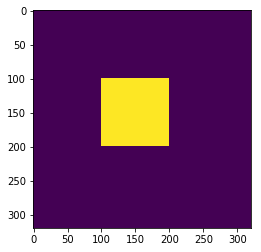

In [3]:
plt.figure()
plt.imshow(trial_image[0,0,:,:])
plt.show()

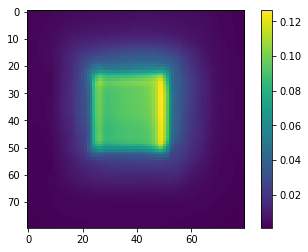

In [4]:
plt.figure()
plt.imshow(hreg[0,0,:,:].data)
plt.colorbar()
plt.show()

In [5]:
hreg.shape

(1, 8, 80, 80)

In [6]:
%env http_proxy http://proxy.ncbs.res.in:3128
%env https_proxy http://proxy.ncbs.res.in:3128

env: http_proxy=http://proxy.ncbs.res.in:3128
env: https_proxy=http://proxy.ncbs.res.in:3128


In [7]:
!git add *


In [8]:
!git commit -m 'Deep direction regression network'

[pawan_files 24e5e77] Deep direction regression network
 2 files changed, 1615 insertions(+), 1317 deletions(-)
 create mode 100644 DDRMOS_network.ipynb
 rewrite TrainingRotation-Pfunctions.ipynb (84%)


In [9]:
!git push 

Git 2.0 from 'matching' to 'simple'. To squelch this message
and maintain the traditional behavior, use:

  git config --global push.default matching

To squelch this message and adopt the new behavior now, use:

  git config --global push.default simple

When push.default is set to 'matching', git will push local branches
to the remote branches that already exist with the same name.

Since Git 2.0, Git defaults to the more conservative 'simple'
behavior, which only pushes the current branch to the corresponding
remote branch that 'git pull' uses to update the current branch.

See 'git help config' and search for 'push.default' for further information.
(the 'simple' mode was introduced in Git 1.7.11. Use the similar mode
'current' instead of 'simple' if you sometimes use older versions of Git)

Counting objects: 4, done.
Delta compression using up to 20 threads.
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 724.64 KiB | 0 bytes/s, done.
Total 4 (delta 1), reused 0